## Ashish Rana
#### 3/6/2017
#### Project 4 - Advanced Lane Finding


In [1]:
# Get all dependencies
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pandas as pd
import pickle
import cv2

from ipywidgets import widgets
from ipywidgets import interact, interactive, IntSlider, FloatSlider
from IPython.display import display

# This is experimentation with the convolution shown in the Q&A session, It is no used
# Because I beleive the window sliding is a better method than convolution with numpy
from tracker import tracker

%matplotlib inline

### Get [mtx] and [dist] from pickled data

In [2]:
# Calibration data imported from pre-calibrated camera data
calibration_data = pickle.load(open("./calibration_pickle.p" , "rb"))

mtx = calibration_data["mtx"]
dist = calibration_data["dist"]

# Images for write up and comparison
timgs_dir = 'test_images\\'
timgs = os.listdir(timgs_dir)

### Perspective Transform test on Chessboard images

In [3]:
# Test Perspective transform on chess board images
def corners_unwarp(img, nx, ny, mtx, dist):
    
    # Undistort, Gray scale, and find chess board corners
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # Draw Corners
    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 
        img_size = (gray.shape[1], gray.shape[0])

        # Perspective transform Source and Destination setup
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        # Perspective Transform
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

### Image Processing

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscla image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Establish Threshold min and max  as seperate variable for clarity
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    # Calculate gradient along x and y axis based on requested orientation
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    
    # Scale to 8bit and define as type unit8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create Mask of 1's where the magnitude is within the max and min threshold.
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # grayscale image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # variables define max min threshold for clarity
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    
    # gradient in each direction
    sobelx =  cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely =  cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    # magnitude of gradient in each direction
    sobelm = np.sqrt(sobelx**2+sobely**2)
    
    # scale to 8 bit
    scaled_sobel = np.uint8(np.max(sobelm)/255)
    
    # Mask of 1's where the magnitude lies within the max and min threshold.
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # grayscale image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # gradient in each direction
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Absolute value of graddients in each direction
    absSOBx =  np.abs(sobelx)
    absSOBy =  np.abs(sobely)
    
    # get direction gradient
    gradmag = np.arctan2(absSOBy,absSOBx) 
    
    # Mask of 1's where the magnitude lies within the max and min threshold.
    dir_binary = np.zeros_like(gradmag)
    dir_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return dir_binary

def hls_hsv_threshold(img, sthresh = (0,255), vthresh = (0,255)):
    # variables define max min threshold for clarity
    sthresh_min = sthresh[0]
    sthresh_max = sthresh[1]
    
    # convert to HLS Space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Filter S channel
    s_channel = hls[:,:,2]
    
    # Maks of 1's where magnitude lies within the max and min of thresholds
    sbinary_output = np.zeros_like(s_channel)
    sbinary_output[(s_channel > sthresh_min) & (s_channel <= sthresh_max)] = 1
    
    # thresh max and min for HSV
    vthresh_min = vthresh[0]
    vthresh_max = vthresh[1]
    
    # convert to HSV Space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Filter V channel
    v_channel = hsv[:,:,2]
    
    # Make of 1's where magnitude lies within the max and min of thresholds
    vbinary_output = np.zeros_like(s_channel)
    vbinary_output[(v_channel > vthresh_min) & (v_channel <= vthresh_max)] = 1
    
    # Create mask of 1's where magnitues of S and V channel WERE within thresholds
    binary_output = np.zeros_like(s_channel)
    binary_output[(sbinary_output==1) & (vbinary_output==1)] = 1
    return binary_output

def binary_img(image,a,b,c,d,e,f):
    # Define Kernel Size
    ksize = 15
    
    # Apply Threshold mins through function input
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(a, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(b, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(c, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(d, 2.0))
    hls_hsv_binary = hls_hsv_threshold(image, sthresh=(e, 255), vthresh=(f, 255))
    
    # Mask of Gradx And HLS + HSV+ Directional Binaries
    combined = np.zeros_like(image[:,:,0])
    combined[(  (gradx==1) |  ((hls_hsv_binary == 1)&(dir_binary==1)) )  ] = 100
    return combined

# This is an experimental function for future experimentation with the Convolution method.
# So far the Convolutional method did not yield good results so the Histogram Peaks + Window 
# Sliding is used.
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output


In [5]:
# Method used to tune parameters before creating functions.
# Easier to tune with a slider GUI interface.
a = widgets.IntSlider(value =20 ,min=0,max=100,step=1,description='gradx Thresh min:')
b = widgets.IntSlider(value =1 ,min=0,max=50,step=1,description='grady Thresh min:')
c = widgets.IntSlider(value =0 ,min=0,max=5,step=1,description='mag Thresh min:')
d = widgets.FloatSlider(value =0.5 ,min=0,max=2.0,step=.05,description='dir Thresh min:')
e = widgets.IntSlider(value =100 ,min=0,max=255,step=1,description='s Thresh min:')
f = widgets.IntSlider(value =200 ,min=0,max=255,step=1,description='v Thresh min:')

# Displaying the variables used
display(a,d,e,f)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [6]:
# Functions below are closely following lessons provided by Udacity 

# *** At this moment there is a redundancy, Blind and a Marginalized Search is being used
# *** for the purposes of this project and to meet time constraints. Future work will introduce
# *** a OOP format and will attempt to introduce classes for image processing and lane detection
# *** to create a Finished Product. The purpose of this is to demonstrate functionality.

# Below is a list of funtions in this block and their utility
        # binary_warp()
            # Used to apply binary filters on undistorted images
            # A Section of the road is transformed
            
        # first_search()
            # Histograms are considered at 9 rectangular slices or Rows
            # Peaks of these histograms are used to determine a line point
            # This is a blind search
            
        # visualize_first_search()
            # This is purely for reporting/demonstrating what the search looks like once done
            
        # line_search_margin()
            # Using the points from Blind Search this constrains the search within a margin
            # Primary difference being the entire row is not searched
            # Then lines are Drawn using the point data
            
        # lanes()
            # This function complies all other function and writes the Radius of Curvature 
            # and Center Offset
            
# Distortion Correction from the Pickle data
def binary_warp(image, mtx, dist):
    # Data is used globally
    global src, dst
    a,b,c,d,e,f = 20,1,0,0.5,100,200
    
    # Undistort
    image = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Apply selected filter and return binary
    binary_warped = binary_img(image,a,b,c,d,e,f)

    # Eastblish percentage of area of interest
    bot_width = 0.78
    mid_width = 0.08
    height_pct  = 0.62
    bottom_trim = 0.935
    offset = 100
    
    cnst_pct = 0.51
    
    # Source and destination points for the 
    img_size =  image.shape[1],image.shape[0]
    src  = np.float32([[  image.shape[1]*(cnst_pct-mid_width/2), image.shape[0]*height_pct],\
                       [  image.shape[1]*(cnst_pct+mid_width/2), image.shape[0]*height_pct],\
                       [  image.shape[1]*(cnst_pct-bot_width/2), image.shape[0]*bottom_trim],\
                       [  image.shape[1]*(cnst_pct+bot_width/2), image.shape[0]*bottom_trim] ])

    dst = np.float32([[offset, 0],\
                      [ img_size[0]-offset, 0],\
                      [offset,  img_size[1]],\
                      [img_size[0]-offset, img_size[1]]])

    # Transform image after applying binary filters 
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    binary_warped = cv2.warpPerspective(binary_warped, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(binary_warped,cmap='gray')
    
    # Return Binary warped
    return binary_warped


def first_search(binary_warped):
    # Cut in half at Y-Axis and get the histogram along the X-Axis
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzero, nonzerox, nonzeroy

def visualize_first_search(out_img, nonzerox, nonzeroy):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Color selected lanes
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return

def line_search_margin(binary_warped, left_lane_inds, right_lane_inds, left_fit, right_fit):
    # Get a new warped binary image 
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # select points from left most side of the Left Lane margin to the right most side of the Left Lane Margin
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    # select points from left most side of the Right Lane margin to the right most side of the Right Lane Margin
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Select points from right side of Left Lane Margin and left side of right lane marign
    mid_line_window1 = np.array([np.transpose(np.vstack([left_fitx+margin/4, ploty]))])
    mid_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx-margin/4, ploty])))])
    mid_line_pts = np.hstack((mid_line_window1,mid_line_window2))
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,50, 100))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,50, 100))
    cv2.fillPoly(window_img, np.int_([mid_line_pts]), (0,150,255))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Return selected variables for plotting and calculations
    return result, left_lane_inds,right_lane_inds, left_fitx, right_fitx, ploty


def lanes(image):
    # Correct distortion
    binary_warped = binary_warp(image, mtx, dist)
    # Get first line
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzero, nonzerox, nonzeroy = first_search(binary_warped)
    
    # Function to plot lines in margin boxes
    # Visualize_first_search(out_img, nonzerox, nonzeroy)
    
    # Get line within a Margin *** This is a knwon redundancy, left here to show both functions
    # are infact working, logic will be introduced when an attempt is made to produce a "Product".
    # This will be done using OOP
    result, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty = line_search_margin(binary_warped, left_lane_inds, right_lane_inds, left_fit, right_fit)

    # Warp Perspective back with lines drawn
    img_size =  image.shape[1],image.shape[0]
    Minv = cv2.getPerspectiveTransform(dst,src)
    road_warped =  cv2.warpPerspective(result, Minv, img_size, flags = cv2.INTER_LINEAR)
    result = cv2.addWeighted(image, 1.0, road_warped, 1.5, 0.0)
    
    # Calculate Radius of Curvature
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    leftx = np.array([left_fitx[-1] + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    rightx = np.array([right_fitx[-1] + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    
    # Max Y-Values
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Camera Offset calculation
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-binary_warped.shape[1]/2)*xm_per_pix
    
    # Word choice based on camera offset
    side_pos = ' left'
    if center_diff <= 0:
        side_pos = ' right'
        
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Write Radius of curvature measurement and Vehicle leaning orientation
    cv2.putText(result, 'Radius of Curvature = ' + str(round((left_curverad+right_curverad)/2,3))+'(m)',(50,50), cv2.FONT_HERSHEY_COMPLEX, 1,(255,255,255),2)
    cv2.putText(result, 'Vehicle is = ' + str(abs(round(center_diff,3)))+'m' +side_pos+ ' of center',(50,100), cv2.FONT_HERSHEY_COMPLEX, 1,(255,255,255),2)
    return result

[MoviePy] >>>> Building video output_vid.mp4
[MoviePy] Writing video output_vid.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:28<00:00,  4.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_vid.mp4 



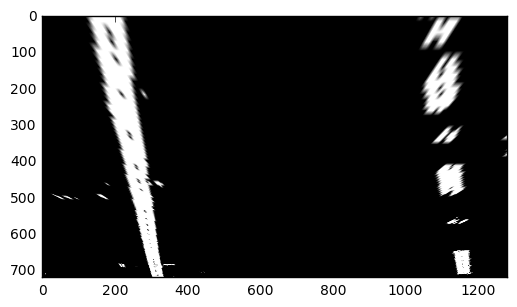

In [7]:
# Process Video with one simple Function
output_video = 'output_vid.mp4'
inp = 'project_video.mp4'

clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(lanes)
video_clip.write_videofile(output_video, audio=False)

